In [1]:
%matplotlib inline
import mhkit
import gridstatus
import numpy as np
import numpy_financial as npf
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
#import PySAM.Pvwattsv8 as pv
#import PySAM.Windpower as wd

from mhkit import wave 
lat_lon = [32.7764,-79.7593]
[ED, AP] = mhkit.river.performance.circular(30)
print(ED)
print(AP)
region = mhkit.wave.io.hindcast.hindcast.region_selection(lat_lon)
print(region)

30
706.8583470577034
Atlantic


In [2]:
data_type = '1-hour' # setting the data type to the 3-hour dataset
years = [1995]
lat_lon = (32.7764,-79.7593)
parameters = ['mean_wave_direction', 'significant_wave_height', 'energy_period']
#parameter_1 = 'mean_wave_direction'
#parameter_2 = 'significant_wave_height'
#parameter_3 = 'energy_period'

Hs, metadata= wave.io.hindcast.hindcast.request_wpto_point_data(data_type,parameters,lat_lon,years)
print("Column names in Hs:", Hs.columns)

E_wave_column_name = 'mean_wave_direction_84'
Hs_column_name = 'significant_wave_height_84' 
T_e_column_name = 'energy_period_84'  

Column names in Hs: Index(['mean_wave_direction_84', 'significant_wave_height_84',
       'energy_period_84'],
      dtype='object')


In [4]:
Hs_data = Hs[Hs_column_name]  
T_e_data = Hs[T_e_column_name]  
Dir_wave = Hs[E_wave_column_name]

In [5]:
print(type(Dir_wave))

<class 'pandas.core.series.Series'>


In [6]:
print("Significant Wave Height (first few rows):", Hs_data.head())
print("Energy Period (first few rows):", T_e_data.head())
print("Mean Wave Direction (first few rows):", Dir_wave.head())

Significant Wave Height (first few rows): time_index
1995-01-01 00:00:00+00:00    2.401733
1995-01-01 01:00:00+00:00    2.346520
1995-01-01 02:00:00+00:00    2.286335
1995-01-01 03:00:00+00:00    2.224740
1995-01-01 04:00:00+00:00    2.165676
Name: significant_wave_height_84, dtype: float32
Energy Period (first few rows): time_index
1995-01-01 00:00:00+00:00    7.417139
1995-01-01 01:00:00+00:00    7.366544
1995-01-01 02:00:00+00:00    7.302242
1995-01-01 03:00:00+00:00    7.228057
1995-01-01 04:00:00+00:00    7.152529
Name: energy_period_84, dtype: float32
Mean Wave Direction (first few rows): time_index
1995-01-01 00:00:00+00:00    110.295990
1995-01-01 01:00:00+00:00    109.737946
1995-01-01 02:00:00+00:00    109.221100
1995-01-01 03:00:00+00:00    108.798767
1995-01-01 04:00:00+00:00    108.487671
Name: mean_wave_direction_84, dtype: float32


In [7]:
# Constants
rho = 1025  # Density of seawater, in kg/m^3
g = 9.81    # Acceleration due to gravity, in m/s^2

# Computing wave power per unit length of wave crest
# The formula: P = (1/16) * rho * g * Hs^2 * Te
P = (1/16) * rho * g * Hs_data**2 * T_e_data  

# Adding the computed wave power as a new column to the DataFrame
Hs['wave_power'] = P

print(Hs[[Hs_column_name, T_e_column_name, 'wave_power']].head())

                           significant_wave_height_84  energy_period_84  \
time_index                                                                
1995-01-01 00:00:00+00:00                    2.401733          7.417139   
1995-01-01 01:00:00+00:00                    2.346520          7.366544   
1995-01-01 02:00:00+00:00                    2.286335          7.302242   
1995-01-01 03:00:00+00:00                    2.224740          7.228057   
1995-01-01 04:00:00+00:00                    2.165676          7.152529   

                             wave_power  
time_index                               
1995-01-01 00:00:00+00:00  26888.023438  
1995-01-01 01:00:00+00:00  25490.900391  
1995-01-01 02:00:00+00:00  23988.818359  
1995-01-01 03:00:00+00:00  22482.939453  
1995-01-01 04:00:00+00:00  21082.376953  


In [8]:
average_P = P.mean()

print("Average wave power (P):", average_P)

Average wave power (P): 5865.3022


In [9]:
Hs['wave_energy_mwh'] = Hs['wave_power'] / 1_000_000

# Optional: Calculate the total energy generated over the DataFrame's time span
total_energy_mwh = Hs['wave_energy_mwh'].sum()

print(Hs[['wave_power', 'wave_energy_mwh']])
print("Total Energy (MWh) over the period:", total_energy_mwh)
Energy = Hs['wave_energy_mwh'] 

                             wave_power  wave_energy_mwh
time_index                                              
1995-01-01 00:00:00+00:00  26888.023438         0.026888
1995-01-01 01:00:00+00:00  25490.900391         0.025491
1995-01-01 02:00:00+00:00  23988.818359         0.023989
1995-01-01 03:00:00+00:00  22482.939453         0.022483
1995-01-01 04:00:00+00:00  21082.376953         0.021082
...                                 ...              ...
1995-12-31 19:00:00+00:00   1306.360352         0.001306
1995-12-31 20:00:00+00:00   1368.768188         0.001369
1995-12-31 21:00:00+00:00   1435.647217         0.001436
1995-12-31 22:00:00+00:00   1508.178101         0.001508
1995-12-31 23:00:00+00:00   1586.504517         0.001587

[8760 rows x 2 columns]
Total Energy (MWh) over the period: 51.380049543601984


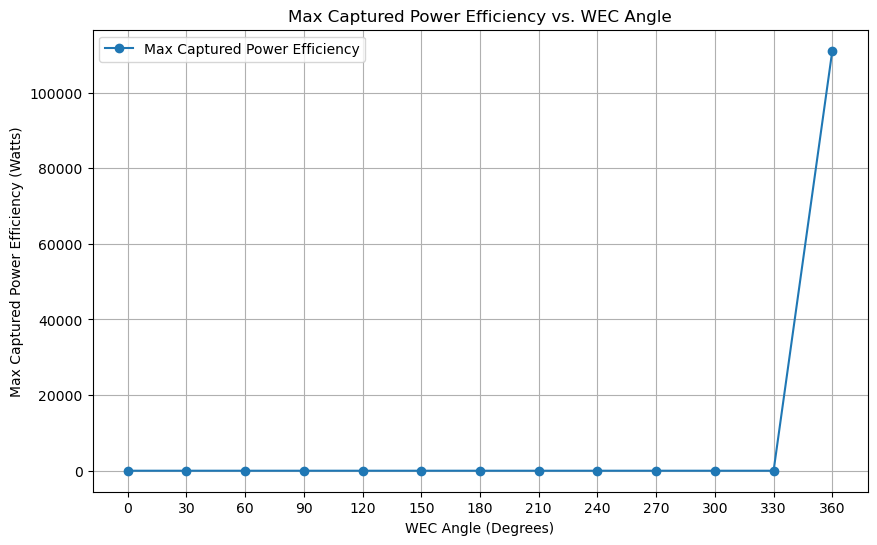

In [10]:
# THIS CODE IS NOT CORRECT/ PLEASE DISREGARD THE OUTPUT; I KEPT IT IN TO TRACK HOW I WORKED THROUGH THIS PART OF THE PROJECT
angles = np.arange(0, 361, 30)  # Angles from 0 to 360 in steps of 30 degrees
efficiencies = []

max_energies = []

wec_angles = np.arange(0, 361, 30)

#mean of the hourly wave direction
# Initialize an array to store the maximum efficiency for each WEC angle
max_efficiencies = np.zeros_like(wec_angles, dtype=float)

# Iterate over each WEC angle
for i, theta in enumerate(wec_angles):
    # Calculate the relative angle between the wave direction and the WEC
    relative_angles = np.abs(Dir_wave - theta) % 360
    efficiencies = np.cos(np.radians(relative_angles))
    captured_powers = P * np.abs(efficiencies)
    
#put this max out of the for loop/sum across within the for loop
# Plotting the maximum efficiency for each WEC angle
max_efficiencies[i] = np.max(captured_powers)
plt.figure(figsize=(10, 6))
plt.plot(wec_angles, max_efficiencies, '-o', label='Max Captured Power Efficiency')

plt.title('Max Captured Power Efficiency vs. WEC Angle')
plt.xlabel('WEC Angle (Degrees)')
plt.ylabel('Max Captured Power Efficiency (Watts)')
plt.xticks(wec_angles)  # Set x-axis ticks to match the WEC angles
plt.grid(True)
plt.legend()
plt.show()


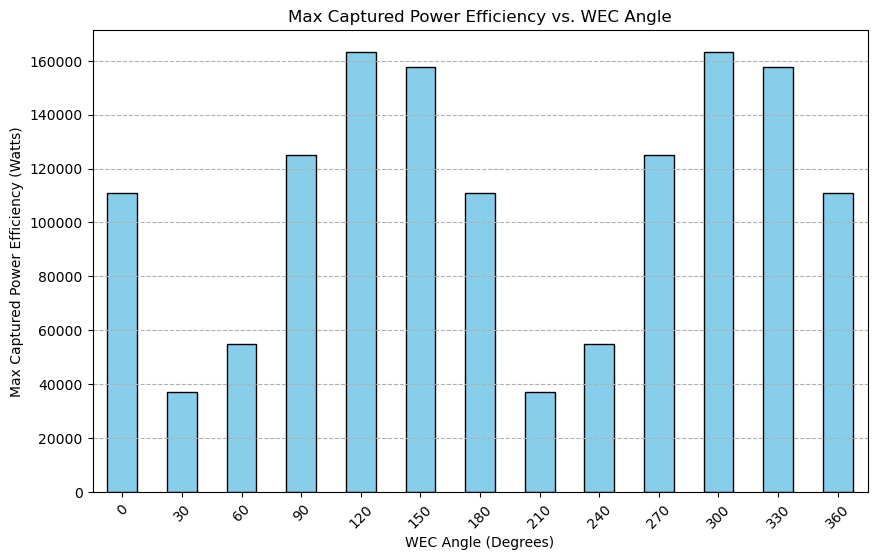

In [11]:
# THIS CODE IS NOT CORRECT/ PLEASE DISREGARD THE OUTPUT; I KEPT IT IN TO TRACK HOW I WORKED THROUGH THIS PART OF THE PROJECT
wec_angles = np.arange(0, 361, 30)  # WEC angles from 0 to 360 in steps of 30 degrees

# Initialize a dictionary to store max efficiency for each WEC angle
max_efficiencies = {}

for theta in wec_angles:
    # Calculate the relative angle between the wave direction and the WEC for each timestamp
    relative_angles = np.abs(Dir_wave - theta) % 360
    efficiencies = np.cos(np.radians(relative_angles))
    
    # Calculate captured powers for each timestamp
    captured_powers = P * np.abs(efficiencies)
    
    # Find the maximum efficiency across all timestamps for this WEC angle
    max_efficiencies[theta] = captured_powers.max()

# Convert max_efficiencies to a Series for easy plotting
max_efficiencies_series = pd.Series(max_efficiencies)

# Plotting the maximum efficiency for each WEC angle
plt.figure(figsize=(10, 6))
max_efficiencies_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Max Captured Power Efficiency vs. WEC Angle')
plt.xlabel('WEC Angle (Degrees)')
plt.ylabel('Max Captured Power Efficiency (Watts)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

[29460840.39244056 20344954.94976983 14937503.85350988 15504205.83823343
 22032099.75812526 30185671.35073118 38164797.11247281 44248438.2253588
 47517961.79603855 47572719.32332787 44387413.23801374 38179300.80680853
 29460840.39244056]
47572719.32332787


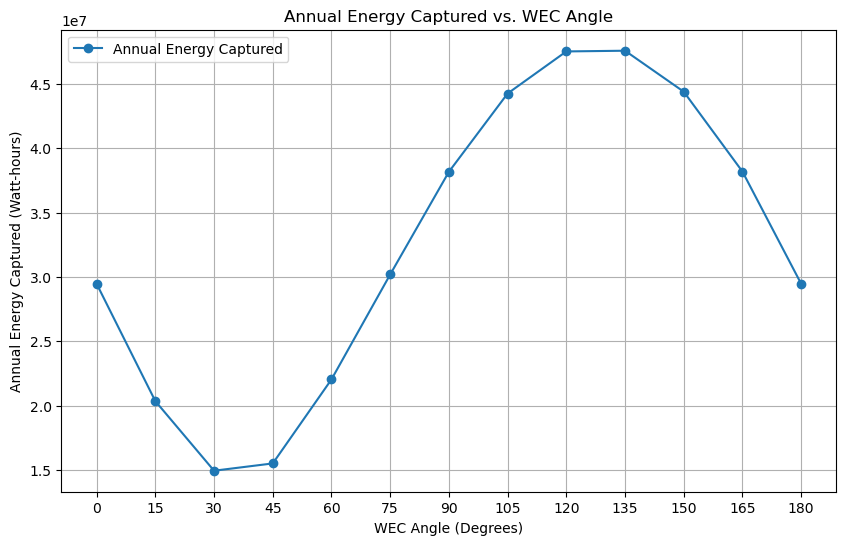

In [12]:
# THIS CODE IS SHOULD BE CORRECT
wec_angles = np.arange(0, 181, 15)

# Initialize a matrix to store captured powers for each combination of WEC angle and wave direction
captured_powers_matrix = np.zeros((len(wec_angles), len(Dir_wave)))

# Iterate over each WEC angle and wave direction to fill the matrix: use iloc function to index the j element of P dataframe
for i, theta in enumerate(wec_angles):
    for t, wave_direction in enumerate(Dir_wave):
        relative_angle = np.abs(wave_direction - theta) % 360
        efficiency = np.cos(np.radians(relative_angle))
        captured_powers_matrix[i, t] = P.iloc[t] * np.abs(efficiency)

# Calculate the maximum efficiency for each WEC angle from the matrix
annual_energy=np.sum(captured_powers_matrix, axis=1)
print(annual_energy)
max_efficiencies = np.max(annual_energy)
print(max_efficiencies)

# Plotting the maximum efficiency for each WEC angle
plt.figure(figsize=(10, 6))
plt.plot(wec_angles, annual_energy, '-o', label='Annual Energy Captured')
plt.title('Annual Energy Captured vs. WEC Angle')
plt.xlabel('WEC Angle (Degrees)')
plt.ylabel('Annual Energy Captured (Watt-hours)')
plt.xticks(wec_angles)
plt.grid(True)
plt.legend()
plt.show()

[29460840.39244056 20344954.94976983 14937503.85350988 15504205.83823343
 22032099.75812526 30185671.35073118 38164797.11247281 44248438.2253588
 47517961.79603855 47572719.32332787 44387413.23801374 38179300.80680853
 29460840.39244056]


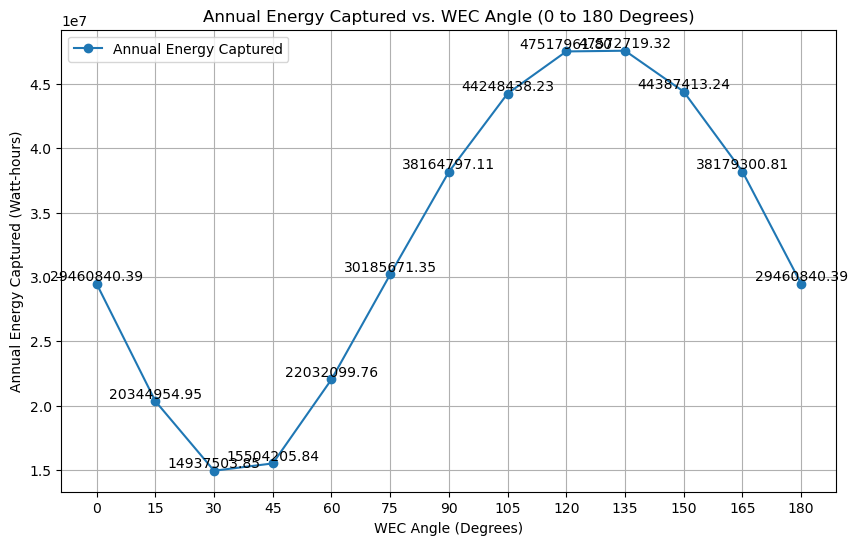

In [13]:
#I only used this section of code to get the maximum energy captured value 
wec_angles = np.arange(0, 181, 15)

# Initialize a matrix to store captured powers for each combination of WEC angle and wave direction
captured_powers_matrix = np.zeros((len(wec_angles), len(Dir_wave)))

# Iterate over each WEC angle and wave direction to fill the matrix: use iloc function to index the j element of P dataframe
for i, theta in enumerate(wec_angles):
    for t, wave_direction in enumerate(Dir_wave):
        relative_angle = np.abs(wave_direction - theta) % 360
        efficiency = np.cos(np.radians(relative_angle))
        captured_powers_matrix[i, t] = P.iloc[t] * np.abs(efficiency)

# Calculate the maximum efficiency for each WEC angle from the matrix
annual_energy=np.sum(captured_powers_matrix, axis=1)
print(annual_energy)
max_efficiencies = np.max(annual_energy)

plt.figure(figsize=(10, 6))
plt.plot(wec_angles, annual_energy, '-o', label='Annual Energy Captured')

# Annotate each point with its value
for angle, energy in zip(wec_angles, annual_energy):
    plt.text(angle, energy, f'{energy:.2f}', ha='center', va='bottom')

plt.title('Annual Energy Captured vs. WEC Angle (0 to 180 Degrees)')
plt.xlabel('WEC Angle (Degrees)')
plt.ylabel('Annual Energy Captured (Watt-hours)')
plt.xticks(wec_angles)
plt.grid(True)
plt.legend()
plt.show()

In [14]:
total_wave_power = Hs['wave_power'].sum()
print("Total wave power: ", total_wave_power)
directional_wave_effect = max_efficiencies/total_wave_power
print(directional_wave_effect)

Total wave power:  51380050.0
0.9258986936588278


In [15]:
def calculate_wave_energy_and_efficiency(lat_lon, years=[1995], data_type='1-hour'):
    # Constants
    rho = 1025  # Density of seawater, in kg/m^3
    g = 9.81    # Acceleration due to gravity, in m/s^2
    parameters = ['mean_wave_direction', 'significant_wave_height', 'energy_period']
    
    # Request wave data
    Hs, metadata= wave.io.hindcast.hindcast.request_wpto_point_data(data_type,parameters,lat_lon,years)
    
    # Dynamically determine the suffix for each parameter column name
    column_names = {}
    for param in parameters:
        for col in Hs.columns:
            if param in col:
                column_names[param] = col  # Capture the full column name including the suffix
                break  # Exit the loop once the first match is found
    
    E_wave_column_name = column_names['mean_wave_direction']
    Hs_column_name = column_names['significant_wave_height']
    T_e_column_name = column_names['energy_period']
    
    # Compute wave power per unit length of wave crest
    P = (1/16) * rho * g * Hs[Hs_column_name]**2 * Hs[T_e_column_name]
    
    # Adding the computed wave power as a new column to the DataFrame
    Hs['wave_power'] = P
    
    # Define WEC angles and initialize captured powers matrix
    wec_angles = np.arange(0, 181, 15)
    Dir_wave = Hs[E_wave_column_name].to_numpy()  # Convert to numpy array for calculations
    captured_powers_matrix = np.zeros((len(wec_angles), len(Dir_wave)))
    
    # Fill the matrix with captured powers
    for i, theta in enumerate(wec_angles):
        for t, wave_direction in enumerate(Dir_wave):
            relative_angle = np.abs(wave_direction - theta) % 360
            efficiency = np.cos(np.radians(relative_angle))
            captured_powers_matrix[i, t] = Hs['wave_power'].iloc[t] * np.abs(efficiency)
    
    # Calculate the maximum efficiency for each WEC angle from the matrix
    annual_energy = np.sum(captured_powers_matrix, axis=1)
    max_efficiency = np.max(annual_energy)
    total_wave_power = Hs['wave_power'].sum()
    directional_wave_effect = max_efficiency/total_wave_power
        
    return annual_energy, max_efficiency, total_wave_power, directional_wave_effect

In [16]:
#this is where the code starts taking a little longer to execute (up to 30 seconds on Alan's laptop for this section)
lat_lon = (32.7764, -79.7593)  # Example coordinates
annual_energy, max_efficiency, total_wave_power, directional_wave_effect = calculate_wave_energy_and_efficiency(lat_lon)
print("Annual energy:", annual_energy)
print("Maximum efficiency:", max_efficiency)
print("Total Power:", total_wave_power)
print("Effect of Direction:", directional_wave_effect)

Annual energy: [29460840.39244056 20344954.94976983 14937503.85350988 15504205.83823343
 22032099.75812526 30185671.35073118 38164797.11247281 44248438.2253588
 47517961.79603855 47572719.32332787 44387413.23801374 38179300.80680853
 29460840.39244056]
Maximum efficiency: 47572719.32332787
Total Power: 51380050.0
Effect of Direction: 0.9258986936588278


In [17]:
#these caclulations are a little tedious as mentioned above; is there anyway to streamline the function? I honestly doubt it, but I can dream
lat_lon = (44.624076, -124.280097) 
annual_energy, max_efficiency, total_wave_power, directional_wave_effect = calculate_wave_energy_and_efficiency(lat_lon)
print("Annual energy:", annual_energy)
print("Maximum efficiency:", max_efficiency)
print("Total Power:", total_wave_power)
print("Effect of Direction:", directional_wave_effect)

Annual energy: [3.63493908e+08 3.59309424e+08 3.30655876e+08 2.80563743e+08
 2.20475584e+08 1.73285130e+08 1.50688757e+08 1.55933005e+08
 1.85778677e+08 2.37153874e+08 2.98951320e+08 3.42906883e+08
 3.63493908e+08]
Maximum efficiency: 363493907.7645279
Total Power: 405646050.0
Effect of Direction: 0.8960864023123132


In [ ]:
lat_lon = (-33.9399, 18.4660)  # Example coordinates
annual_energy, max_efficiency, total_wave_power, directional_wave_effect = calculate_wave_energy_and_efficiency(lat_lon)
print("Annual energy:", annual_energy)
print("Maximum efficiency:", max_efficiency)
print("Total Power:", total_wave_power)
print("Effect of Direction:", directional_wave_effect)

ERROR:root:connection error: HTTPSConnectionPool(host='developer.nrel.gov', port=443): Max retries exceeded with url: /api/hsds/datasets/d-9db3e298-adf30787-e319-5bd45f-9cc267/attributes/scale_factor?domain=%2Fnrel%2FUS_wave%2Fvirtual_buoy%2FWest_Coast%2FWest_Coast_virtual_buoy_1995.h5&api_key=ELeMHmKCpBmNm5J2mWfZI8mpn9EZzI4HxeKDGzsB (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001D67C3783A0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))


ERROR:root:connection error: HTTPSConnectionPool(host='developer.nrel.gov', port=443): Max retries exceeded with url: /api/hsds/datasets/d-9db3e298-adf30787-e319-5bd45f-9cc267/attributes/add_offset?domain=%2Fnrel%2FUS_wave%2Fvirtual_buoy%2FWest_Coast%2FWest_Coast_virtual_buoy_1995.h5&api_key=ELeMHmKCpBmNm5J2mWfZI8mpn9EZzI4HxeKDGzsB (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001D67C37D610>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))


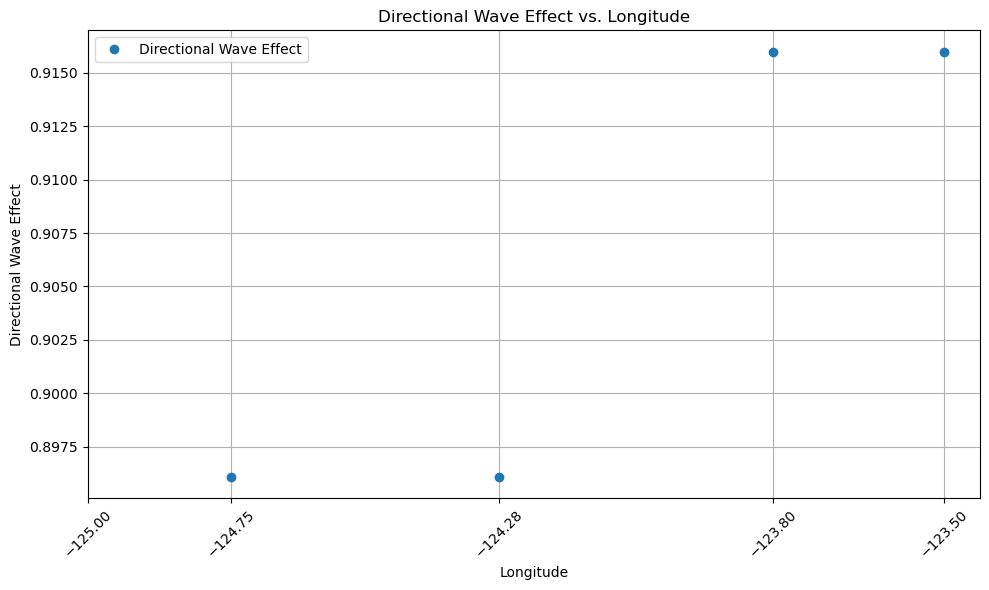

In [22]:
# Define the list of locations
locations = [
    (44.624076, -124.280097),
    (32.7764, -79.7593),
    (44.624076, -123.500097)
]

directional_wave_effects = []

for lat_lon in locations:
    _, _, _, directional_wave_effect = calculate_wave_energy_and_efficiency(lat_lon)
    directional_wave_effects.append(directional_wave_effect)

# Extract longitude values for the x-axis
longitudes = [lon for _, lon in locations]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(longitudes, directional_wave_effects, 'o', label='Directional Wave Effect')
plt.title('Directional Wave Effect vs. Longitude')
plt.xlabel('Longitude')
plt.ylabel('Directional Wave Effect')
plt.xticks(longitudes, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout() 
plt.show()

In [23]:
def plot_directional_wave_effects(locations, years=[1995], data_type='1-hour'):
    # Initialize lists to store results
    directional_wave_effects = []
    longitudes = []

    
    for lat_lon in locations:
        try:
            _, _, _, directional_wave_effect = calculate_wave_energy_and_efficiency(lat_lon, years, data_type)
            directional_wave_effects.append(directional_wave_effect)
            longitudes.append(lat_lon[1])  # Append longitude for plotting
        except Exception as e:
            print(f"Error processing location {lat_lon}: {e}")
            directional_wave_effects.append(None)  
            longitudes.append(lat_lon[1])  

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(longitudes, directional_wave_effects, 'o', label='Directional Wave Effect')
    plt.title('Directional Wave Effect vs. Longitude')
    plt.xlabel('Longitude')
    plt.ylabel('Directional Wave Effect')
    plt.xticks(longitudes, labels=[f"{lon:.2f}" for lon in longitudes], rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()  
    plt.show()

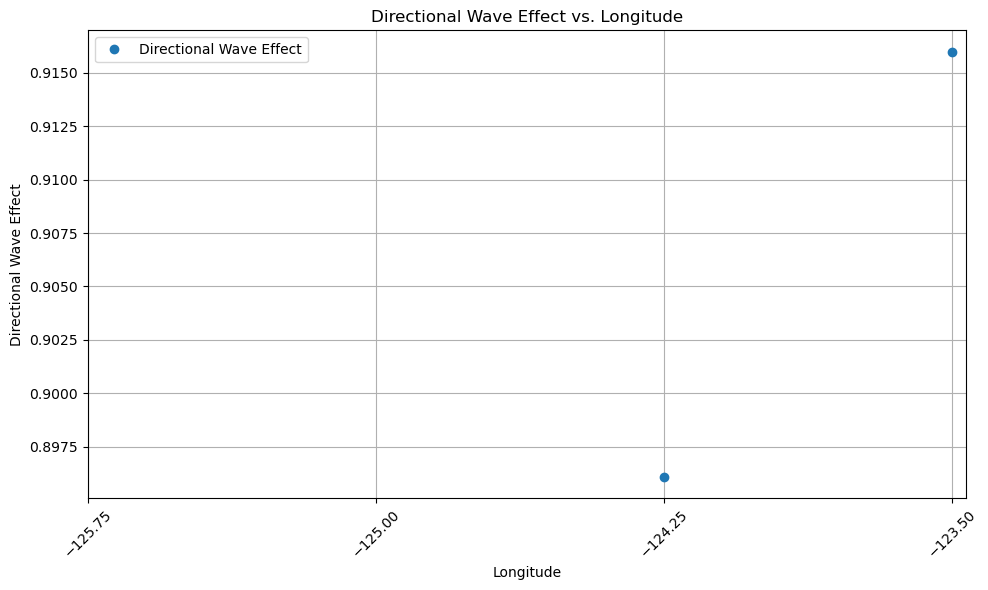

In [21]:
locations = [
    (44.624076, -125.750097),
    (44.624076, -124.250097),
    (44.624076, -123.500097),
]

directional_wave_effects = []

for lat_lon in locations:
    _, _, _, directional_wave_effect = calculate_wave_energy_and_efficiency(lat_lon)
    directional_wave_effects.append(directional_wave_effect)

# Extract longitude values for the x-axis
longitudes = [lon for _, lon in locations]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(longitudes, directional_wave_effects, 'o', label='Directional Wave Effect')
plt.title('Directional Wave Effect vs. Longitude')
plt.xlabel('Longitude')
plt.ylabel('Directional Wave Effect')
plt.xticks(longitudes, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout() 
plt.show()

In [ ]:
plot_directional_wave_effects(locations)

In [ ]:
#This mhkit only applies to US based locations
locations_1 = [
    (-33.9399, 18.4660),  # Cape Town, South Africa
    (13.0827, 80.2707),   # Bay of Bengal, near Chennai, India
    (-20.3484, 57.5522),  # Mauritius, Indian Ocean
    (24.4667, -81.7832),  # Near Key West, Florida, USA
    (-45.0311, 168.6626)  # Southwest of New Zealand, Pacific Ocean
]

In [ ]:
plot_directional_wave_effects(locations_1)

In [ ]:
locations_2 = [
    (44.624076, -124.280097),
    (44.624076, -124.750097),
    (44.624076, -125.000097),
    (44.624076, -123.800097),
    (44.624076, -123.500097)
]

In [ ]:
plot_directional_wave_effects(locations_2)

In [10]:
url = 'https://raw.githubusercontent.com/NREL/SAM/develop/deploy/wave_resource_ts/lat40.84_lon-124.25__2010.csv'
download = requests.get(url).content
file = io.StringIO(download.decode('utf-8'))
parser = lambda y,m,d,H,M: pd.datetime.strptime(f"{y}.{m}.{d}.{H}.{M}", "%Y.%m.%d.%H.%M")

wave_data_2 = pd.read_csv(file, skiprows = 2, parse_dates={"Time":[0,1,2,3,4]}, date_parser=parser)
wave_data_2 = wave_data_2[['Time','Significant Wave Height','Energy Period']].set_index("Time")
wave_data_2.index = wave_data_2.index.tz_localize('US/Pacific') + pd.offsets.DateOffset(years=11) # fake it starting in 2021
wave_data_2.head()



,Significant Wave Height,Energy Period
Time,,
2021-01-01 00:00:00-08:00,3.21103,9.0149
2021-01-01 03:00:00-08:00,3.13325,9.2803
2021-01-01 06:00:00-08:00,3.32286,8.8879
2021-01-01 09:00:00-08:00,3.35948,8.8694
2021-01-01 12:00:00-08:00,3.33115,9.3399


In [6]:
# CAISO data
caiso = gridstatus.CAISO()
start = pd.Timestamp("Jan 1, 2021").normalize()
end = pd.Timestamp("Dec 31, 2021").normalize()
#lmp = caiso.get_lmp(start=start, end=end, market='REAL_TIME_HOURLY', 
#                    locations=["EUREKAA_6_N001"])
lmp = pd.read_csv('lmp-eureka-2021.csv',index_col=1)
lmp.index = pd.to_datetime(lmp.index,utc=True).tz_convert('US/Pacific')
print(len(lmp))

34832


In [7]:
rho = 1025
g = 9.8
coeff = rho*(g**2)/(64*np.pi)
wave_data_2["J"] = coeff*wave_data_2["Significant Wave Height"]**2*wave_data_2["Energy Period"]
CW = 10*50 # total capture width of WEC, m (assuming array of 50, with 10m each)
wave_data_2["P"] = wave_data_2["J"] * CW # power of WEC, W
print(len(wave_data_2["P"]))
#print(wave_data_2["J"])
#print(wave_data_2["P"])
#len_wd2p = len(wave_data_2["P"])
#print(len_wd2p)

2920


In [8]:
dfs = [lmp, wave_data_2["P"]]
end_date = pd.Timestamp("Dec 31, 2021").normalize()
dfs_resampled = [df.loc[:end_date].resample('60min').mean().interpolate() for df in dfs]
#print(dfs_resampled)

In [9]:
resampled_lmp = dfs_resampled[0]["LMP"]  # Access the resampled 'lmp' DataFrame
resampled_wave_power = dfs_resampled[1]
resampled_wave_power = resampled_wave_power.iloc[:-1]
#print(resampled_lmp)
#print(resampled_wave_power)
print(len(resampled_lmp))
print(len(resampled_wave_power))

8736
8736


In [ ]:
W_to_MWh = 15/60 * 10**-6 # for 15min timestep
revenue = W_to_MWh * np.dot(resampled_wave_power, resampled_lmp)
print(revenue)

In [ ]:
rate = 0.08 # interest rate
N_WEC = 1

#capex computation
development     = 4553000;
infrastructure  = 990000;
mooring         = N_WEC * 525000
pto             = N_WEC * 623000
profitmargin    = 356000
installation    = 5909000
contingency     = 1590000
capex = development + infrastructure + mooring + pto + profitmargin + installation + contingency

In [ ]:
#opex computation
operations = N_WEC * 27000;
postinstall = 710000;
shoreoperations = 142000;
replacement = N_WEC * 54000;
consumables = N_WEC * 8000;
insurance = (.8 + .2*N_WEC) * 227000;
opex = operations + postinstall + shoreoperations + replacement + consumables + insurance

In [ ]:
profit_year = revenue - opex

lifetime = 20 #years
cashflow_total = profit_year * lifetime
initial_capex = -1*capex

cashflow = np.full( (lifetime,), profit_year)
#transform into python list to insert the initial capex value
cashflow_list=cashflow.tolist()
cashflow_list.insert(0,initial_capex)
cashflow=np.array(cashflow_list)
#print(cashflow)
npv_values = np.zeros(len(cashflow))
for i in range(len(cashflow)):
     npv_values[i] = (npf.npv(rate, cashflow[:i+1])) 
time = np.arange(len(cashflow))
for t in (time):
     npv_values[t] = npf.npv(rate, cashflow[:t+1])       
print(npv_values)

plt.plot(time, npv_values, marker = 'o')
plt.xlabel("Time")
plt.ylabel("NPV")
plt.title("NPV Over Time")
plt.show()

In [ ]:
# plot CAISO data
for i in range(0,2):
    fig, ax = plt.subplots()
    ax.scatter(lmp.index, lmp["LMP"])
    ax.set(xlabel='Time', ylabel='LMP ($/MWh)', title='CAISO Eureka Node 2021')
    ax.grid()
    if i==1:
        plt.xlim([lmp.index[0], lmp.index[24*4]])
        plt.ylim([0,50])
    #plt.savefig('figs/caiso-data-'+f"{i}"+'.png')

In [ ]:
metadata

In [ ]:
Hs.head()

In [ ]:
locations = [
    (44.624076, -124.280097),  # Location 1 (original location, Newport, Oregon)
    (44.624076, -124.750097),  #remaning locations move west or east along the same longitude 
    (44.624076, -125.000097), 
    (44.624076, -123.800097), 
    (44.624076, -123.500097), 
]

In [ ]:
data_type = '1-hour'  # Setting the data type
years = [1995]  # Define the years for which you want data
parameters = ['mean_wave_direction', 'significant_wave_height', 'energy_period']

# Dictionary to hold data for all locations
all_locations_data = {}

for i, (lat, lon) in enumerate(locations):
    lat_lon = (lat, lon)
    
    # Request data for the current location
    Hs, metadata = mhkit.wave.io.hindcast.hindcast.request_wpto_point_data(data_type, parameters, lat_lon, years)
    
    # Store the data and metadata in the dictionary
    all_locations_data[f"Location_{i+1}"] = {
        "Data": Hs,
        "Metadata": metadata
    }

    # Optional: Print out confirmation or summary of the data pulled
    print(f"Data pulled for Location {i+1}: {lat_lon}")
    print("Column names in Hs:", Hs.columns)